# CAPA 1

In [9]:
# -*- coding: utf-8 -*-
from __future__ import annotations
from typing import Literal
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# Tipos literales para etiquetas lingüísticas
Fase   = Literal['Floracion', 'Cuajado', 'PostEnvero', 'PostCosecha']
Estres = Literal['estres_severo', 'estres_fuerte', 'estres_moderado', 'estres_leve', 'sin_estres']

class Capa1ConPrioridadKS:
    """
    Capa 1: Sistema de Inferencia Difusa Mamdani (núcleo decisional).
    
    Traduce el estado biofísico (Ks, fase fenológica) en criterios de riego mediante
    lógica difusa. Implementa un sistema Mamdani clásico con operadores min-max y
    defuzzificación por centroide, integrando conocimiento experto local para
    Tempranillo bajo estrategia orientada a calidad.
    
    Entradas:
      - DOY: día del año [99-285], define fase fenológica mediante funciones de pertenencia
      - Ks: coeficiente de estrés hídrico [0-1] de la Capa 0
    
    Salidas:
      - pct_dnd: porcentaje de demanda neta diaria a reponer [0-130%]
      - prioridad: urgencia de riego [0-1], independiente de la dosis
      - fase: etiqueta de fase fenológica actual
    
    La separación dosis/urgencia permite que la Capa 2 ajuste la respuesta operativa
    según restricciones (horas disponibles, caudal, previsión de lluvia) sin perder
    coherencia estratégica.
    """
    
    def __init__(self):
        # Definición de universos de discurso
        self.KS  = ctrl.Antecedent(np.linspace(0.0, 1.0, 101), 'KS')  # Estrés hídrico
        self.DOY = ctrl.Antecedent(np.linspace(99, 285, 285-99+1), 'DOY')  # Día juliano campaña
        
        self.pct  = ctrl.Consequent(np.linspace(0, 130, 261), 'pct_dnd')  # % de DND
        self.Pout = ctrl.Consequent(np.linspace(0, 1.0, 101), 'PrioridadBase')  # Urgencia
        
        # Conjuntos difusos de Ks (niveles de estrés hídrico)
        # Solapamiento permite transiciones suaves entre estados
        self.KS['estres_severo']   = fuzz.trapmf(self.KS.universe, [0.00, 0.00, 0.15, 0.30])
        self.KS['estres_fuerte']   = fuzz.trimf(self.KS.universe,  [0.20, 0.325, 0.45])
        self.KS['estres_moderado'] = fuzz.trimf(self.KS.universe,  [0.35, 0.5, 0.65])
        self.KS['estres_leve']     = fuzz.trimf(self.KS.universe,  [0.55, 0.7, 0.85])
        self.KS['sin_estres']      = fuzz.trapmf(self.KS.universe, [0.75, 0.9, 1.00, 1.00])
        
        # Conjuntos difusos de DOY (fases fenológicas)
        # Rangos basados en fenología típica de Tempranillo en zona centro-norte
        self.DOY['Floracion']   = fuzz.trapmf(self.DOY.universe, [99, 99, 158, 171])  # ~Abril-Mayo
        self.DOY['Cuajado']     = fuzz.trapmf(self.DOY.universe, [158, 171, 201, 213])  # ~Mayo-Junio
        self.DOY['PostEnvero']  = fuzz.trapmf(self.DOY.universe, [201, 213, 227, 248])  # ~Julio-Agosto
        self.DOY['PostCosecha'] = fuzz.trapmf(self.DOY.universe, [227, 248, 285, 285])  # ~Septiembre
        
        # Conjuntos difusos de %DND (porcentaje de demanda neta diaria)
        self.pct['Cero']     = fuzz.trapmf(self.pct.universe, [0, 0, 0, 0])  # Sin riego
        self.pct['MuyBaja']  = fuzz.trapmf(self.pct.universe, [0, 0, 10, 25])  # Déficit severo
        self.pct['Baja']     = fuzz.trimf(self.pct.universe,  [10, 25, 40])  # Déficit moderado
        self.pct['Media']    = fuzz.trimf(self.pct.universe,  [25, 45, 65])  # Reposición parcial
        self.pct['Alta']     = fuzz.trimf(self.pct.universe,  [45, 65, 85])  # Reposición alta
        self.pct['MuyAlta']  = fuzz.trimf(self.pct.universe,  [65, 85, 105])  # Reposición completa+
        self.pct['Extremo']  = fuzz.trapmf(self.pct.universe, [85, 110, 130, 130])  # Urgencia máxima
        self.pct.defuzzify_method = 'centroid'
        
        # Conjuntos difusos de Prioridad (urgencia de riego)
        self.Pout['Baja']  = fuzz.trapmf(self.Pout.universe, [0.00, 0.00, 0.25, 0.50])  # Puede esperar
        self.Pout['Media'] = fuzz.trimf(self.Pout.universe,  [0.25, 0.50, 0.75])  # Atención moderada
        self.Pout['Alta']  = fuzz.trapmf(self.Pout.universe, [0.50, 0.75, 1.00, 1.00])  # Urgente
        self.Pout.defuzzify_method = 'centroid'
        
        # Base de reglas difusas (Fase × Ks) → (pct_dnd, Prioridad)
        # Estructura: 4 fases × 5 niveles de estrés = 20 reglas
        rules = []
        
        # FLORACIÓN: fase crítica, evitar déficits para no comprometer fecundación/cuajado
        # Estrategia: reposición alta incluso con estrés leve
        rules += [
            ctrl.Rule(self.DOY['Floracion'] & self.KS['estres_severo'],   (self.pct['Extremo'],  self.Pout['Alta'])),
            ctrl.Rule(self.DOY['Floracion'] & self.KS['estres_fuerte'],   (self.pct['Extremo'],  self.Pout['Alta'])),
            ctrl.Rule(self.DOY['Floracion'] & self.KS['estres_moderado'], (self.pct['Extremo'],  self.Pout['Alta'])),
            ctrl.Rule(self.DOY['Floracion'] & self.KS['estres_leve'],     (self.pct['MuyAlta'],  self.Pout['Media'])),
            ctrl.Rule(self.DOY['Floracion'] & self.KS['sin_estres'],      (self.pct['Alta'],     self.Pout['Baja'])),
        ]
        
        # CUAJADO: inicio de déficit controlado, reducir vigor excesivo
        # Estrategia: modular según estrés, comenzar a tolerar déficit leve
        rules += [
            ctrl.Rule(self.DOY['Cuajado'] & self.KS['estres_severo'],   (self.pct['MuyAlta'], self.Pout['Alta'])),
            ctrl.Rule(self.DOY['Cuajado'] & self.KS['estres_fuerte'],   (self.pct['Alta'],    self.Pout['Alta'])),
            ctrl.Rule(self.DOY['Cuajado'] & self.KS['estres_moderado'], (self.pct['Media'],   self.Pout['Media'])),
            ctrl.Rule(self.DOY['Cuajado'] & self.KS['estres_leve'],     (self.pct['Baja'],    self.Pout['Media'])),
            ctrl.Rule(self.DOY['Cuajado'] & self.KS['sin_estres'],      (self.pct['MuyBaja'], self.Pout['Baja'])),
        ]
        
        # POST-ENVERO: déficit hídrico controlado para concentración fenólica
        # Estrategia: tolerar estrés moderado, favorecer calidad sobre rendimiento
        rules += [
            ctrl.Rule(self.DOY['PostEnvero'] & self.KS['estres_severo'],   (self.pct['MuyAlta'], self.Pout['Alta'])),
            ctrl.Rule(self.DOY['PostEnvero'] & self.KS['estres_fuerte'],   (self.pct['Media'],   self.Pout['Media'])),
            ctrl.Rule(self.DOY['PostEnvero'] & self.KS['estres_moderado'], (self.pct['Baja'],    self.Pout['Baja'])),
            ctrl.Rule(self.DOY['PostEnvero'] & self.KS['estres_leve'],     (self.pct['MuyBaja'], self.Pout['Baja'])),
            ctrl.Rule(self.DOY['PostEnvero'] & self.KS['sin_estres'],      (self.pct['Cero'],    self.Pout['Baja'])),
        ]
        
        # POST-COSECHA: mantener viabilidad de la planta, evitar estrés extremo
        # Estrategia: riego de supervivencia, preparación para próxima campaña
        rules += [
            ctrl.Rule(self.DOY['PostCosecha'] & self.KS['estres_severo'],   (self.pct['MuyAlta'], self.Pout['Alta'])),
            ctrl.Rule(self.DOY['PostCosecha'] & self.KS['estres_fuerte'],   (self.pct['Alta'],    self.Pout['Alta'])),
            ctrl.Rule(self.DOY['PostCosecha'] & self.KS['estres_moderado'], (self.pct['Media'],   self.Pout['Media'])),
            ctrl.Rule(self.DOY['PostCosecha'] & self.KS['estres_leve'],     (self.pct['Baja'],    self.Pout['Baja'])),
            ctrl.Rule(self.DOY['PostCosecha'] & self.KS['sin_estres'],      (self.pct['Cero'],    self.Pout['Baja'])),
        ]
        
        # Construcción del sistema de control difuso
        self._system = ctrl.ControlSystem(rules)
    
    def evaluar(self, doy: float, ks: float) -> dict:
        """
        Evalúa el sistema difuso para un día específico.
        
        Parámetros:
            doy: día juliano [99-285]
            ks: coeficiente de estrés hídrico [0-1]
        
        Retorna:
            dict con 'pct_dnd' (%), 'prioridad' [0-1], 'fase' (str)
        """
        # Clip a universos de discurso para evitar errores fuera de rango
        doy = float(np.clip(doy, 99, 285))
        ks  = float(np.clip(ks,  0.0, 1.0))
        
        # Simulación del sistema difuso
        sim = ctrl.ControlSystemSimulation(self._system)
        sim.input['DOY'] = doy
        sim.input['KS']  = ks
        sim.compute()
        
        return {
            'pct_dnd': round(float(sim.output['pct_dnd']), 2),
            'prioridad': round(float(sim.output['PrioridadBase']), 3),
            'fase': self._fase_label_por_max_mu(doy),
        }
    
    def _fase_label_por_max_mu(self, doy: float) -> Fase:
        """
        Determina la fase fenológica por máximo grado de pertenencia.
        Útil para etiquetado y trazabilidad, evitando ambigüedad en zonas de solapamiento.
        """
        mu = {
            'Floracion':   fuzz.interp_membership(self.DOY.universe, self.DOY.terms['Floracion'].mf,  doy),
            'Cuajado':     fuzz.interp_membership(self.DOY.universe, self.DOY.terms['Cuajado'].mf,    doy),
            'PostEnvero':  fuzz.interp_membership(self.DOY.universe, self.DOY.terms['PostEnvero'].mf, doy),
            'PostCosecha': fuzz.interp_membership(self.DOY.universe, self.DOY.terms['PostCosecha'].mf, doy),
        }
        return max(mu, key=mu.get)  # type: ignore[return-value]

In [10]:
# -------- Ejemplo mínimo --------
if __name__ == "__main__":
    capa1 = Capa1ConPrioridadKS()
    capa1.visualizar_variables()

    casos = [
        ("Floración, Ks=0.55",   185, 0.598),
        ("Cuajado,   Ks=0.80",   175, 0.80),
        ("Post-Envero, Ks=0.60", 220, 0.60),
        ("Cuajado,   Ks=0.35",   185, 0.35),
    ]
    for desc, doy, ks in casos:
        out = capa1.evaluar(doy=doy, ks=ks)
        print(f"{desc:28s} -> %DND={out['pct_dnd']:5.1f}  P={out['prioridad']:0.2f}  fase={out['fase']}")

AttributeError: 'Capa1ConPrioridadKS' object has no attribute 'visualizar_variables'

In [5]:
# -*- coding: utf-8 -*-
from __future__ import annotations
from typing import Literal
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt

# Tipos literales para etiquetas lingüísticas
Fase   = Literal['Floracion', 'Cuajado', 'PostEnvero', 'PostCosecha']
Estres = Literal['estres_severo', 'estres_fuerte', 'estres_moderado', 'estres_leve', 'sin_estres']

class Capa1ConPrioridadKS:
    """
    Capa 1: Sistema de Inferencia Difusa Mamdani (núcleo decisional).
    
    Traduce el estado biofísico (Ks, fase fenológica) en criterios de riego mediante
    lógica difusa. Implementa un sistema Mamdani clásico con operadores min-max y
    defuzzificación por centroide, integrando conocimiento experto local para
    Tempranillo bajo estrategia orientada a calidad.
    
    Entradas:
      - DOY: día del año [99-285], define fase fenológica mediante funciones de pertenencia
      - Ks: coeficiente de estrés hídrico [0-1] de la Capa 0
    
    Salidas:
      - pct_dnd: porcentaje de demanda neta diaria a reponer [0-130%]
      - prioridad: urgencia de riego [0-1], independiente de la dosis
      - fase: etiqueta de fase fenológica actual
    
    La separación dosis/urgencia permite que la Capa 2 ajuste la respuesta operativa
    según restricciones (horas disponibles, caudal, previsión de lluvia) sin perder
    coherencia estratégica.
    """
    
    def __init__(self):
        # Definición de universos de discurso
        self.KS  = ctrl.Antecedent(np.linspace(0.0, 1.0, 101), 'KS')  # Estrés hídrico
        self.DOY = ctrl.Antecedent(np.linspace(99, 285, 285-99+1), 'DOY')  # Día juliano campaña
        
        self.pct  = ctrl.Consequent(np.linspace(0, 130, 261), 'pct_dnd')  # % de DND
        self.Pout = ctrl.Consequent(np.linspace(0, 1.0, 101), 'PrioridadBase')  # Urgencia
        
        # Conjuntos difusos de Ks (niveles de estrés hídrico)
        # Solapamiento permite transiciones suaves entre estados
        self.KS['estres_severo']   = fuzz.trapmf(self.KS.universe, [0.00, 0.00, 0.15, 0.30])
        self.KS['estres_fuerte']   = fuzz.trimf(self.KS.universe,  [0.20, 0.325, 0.45])
        self.KS['estres_moderado'] = fuzz.trimf(self.KS.universe,  [0.35, 0.5, 0.65])
        self.KS['estres_leve']     = fuzz.trimf(self.KS.universe,  [0.55, 0.7, 0.85])
        self.KS['sin_estres']      = fuzz.trapmf(self.KS.universe, [0.75, 0.9, 1.00, 1.00])
        
        # Conjuntos difusos de DOY (fases fenológicas)
        # Rangos basados en fenología típica de Tempranillo en zona centro-norte
        self.DOY['Floracion']   = fuzz.trapmf(self.DOY.universe, [99, 99, 158, 171])  # ~Abril-Mayo
        self.DOY['Cuajado']     = fuzz.trapmf(self.DOY.universe, [158, 171, 201, 213])  # ~Mayo-Junio
        self.DOY['PostEnvero']  = fuzz.trapmf(self.DOY.universe, [201, 213, 227, 248])  # ~Julio-Agosto
        self.DOY['PostCosecha'] = fuzz.trapmf(self.DOY.universe, [227, 248, 285, 285])  # ~Septiembre
        
        # Conjuntos difusos de %DND (porcentaje de demanda neta diaria)
        self.pct['Cero']     = fuzz.trapmf(self.pct.universe, [0, 0, 0, 0])  # Sin riego
        self.pct['MuyBaja']  = fuzz.trapmf(self.pct.universe, [0, 0, 10, 25])  # Déficit severo
        self.pct['Baja']     = fuzz.trimf(self.pct.universe,  [10, 25, 40])  # Déficit moderado
        self.pct['Media']    = fuzz.trimf(self.pct.universe,  [25, 45, 65])  # Reposición parcial
        self.pct['Alta']     = fuzz.trimf(self.pct.universe,  [45, 65, 85])  # Reposición alta
        self.pct['MuyAlta']  = fuzz.trimf(self.pct.universe,  [65, 85, 105])  # Reposición completa+
        self.pct['Extremo']  = fuzz.trapmf(self.pct.universe, [85, 110, 130, 130])  # Urgencia máxima
        self.pct.defuzzify_method = 'centroid'
        
        # Conjuntos difusos de Prioridad (urgencia de riego)
        self.Pout['Baja']  = fuzz.trapmf(self.Pout.universe, [0.00, 0.00, 0.25, 0.50])  # Puede esperar
        self.Pout['Media'] = fuzz.trimf(self.Pout.universe,  [0.25, 0.50, 0.75])  # Atención moderada
        self.Pout['Alta']  = fuzz.trapmf(self.Pout.universe, [0.50, 0.75, 1.00, 1.00])  # Urgente
        self.Pout.defuzzify_method = 'centroid'
        
        # Base de reglas difusas (Fase × Ks) → (pct_dnd, Prioridad)
        # Estructura: 4 fases × 5 niveles de estrés = 20 reglas
        rules = []
        
        # FLORACIÓN: fase crítica, evitar déficits para no comprometer fecundación/cuajado
        # Estrategia: reposición alta incluso con estrés leve
        rules += [
            ctrl.Rule(self.DOY['Floracion'] & self.KS['estres_severo'],   (self.pct['Extremo'],  self.Pout['Alta'])),
            ctrl.Rule(self.DOY['Floracion'] & self.KS['estres_fuerte'],   (self.pct['Extremo'],  self.Pout['Alta'])),
            ctrl.Rule(self.DOY['Floracion'] & self.KS['estres_moderado'], (self.pct['Extremo'],  self.Pout['Alta'])),
            ctrl.Rule(self.DOY['Floracion'] & self.KS['estres_leve'],     (self.pct['MuyAlta'],  self.Pout['Media'])),
            ctrl.Rule(self.DOY['Floracion'] & self.KS['sin_estres'],      (self.pct['Alta'],     self.Pout['Baja'])),
        ]
        
        # CUAJADO: inicio de déficit controlado, reducir vigor excesivo
        # Estrategia: modular según estrés, comenzar a tolerar déficit leve
        rules += [
            ctrl.Rule(self.DOY['Cuajado'] & self.KS['estres_severo'],   (self.pct['MuyAlta'], self.Pout['Alta'])),
            ctrl.Rule(self.DOY['Cuajado'] & self.KS['estres_fuerte'],   (self.pct['Alta'],    self.Pout['Alta'])),
            ctrl.Rule(self.DOY['Cuajado'] & self.KS['estres_moderado'], (self.pct['Media'],   self.Pout['Media'])),
            ctrl.Rule(self.DOY['Cuajado'] & self.KS['estres_leve'],     (self.pct['Baja'],    self.Pout['Media'])),
            ctrl.Rule(self.DOY['Cuajado'] & self.KS['sin_estres'],      (self.pct['MuyBaja'], self.Pout['Baja'])),
        ]
        
        # POST-ENVERO: déficit hídrico controlado para concentración fenólica
        # Estrategia: tolerar estrés moderado, favorecer calidad sobre rendimiento
        rules += [
            ctrl.Rule(self.DOY['PostEnvero'] & self.KS['estres_severo'],   (self.pct['MuyAlta'], self.Pout['Alta'])),
            ctrl.Rule(self.DOY['PostEnvero'] & self.KS['estres_fuerte'],   (self.pct['Media'],   self.Pout['Media'])),
            ctrl.Rule(self.DOY['PostEnvero'] & self.KS['estres_moderado'], (self.pct['Baja'],    self.Pout['Baja'])),
            ctrl.Rule(self.DOY['PostEnvero'] & self.KS['estres_leve'],     (self.pct['MuyBaja'], self.Pout['Baja'])),
            ctrl.Rule(self.DOY['PostEnvero'] & self.KS['sin_estres'],      (self.pct['Cero'],    self.Pout['Baja'])),
        ]
        
        # POST-COSECHA: mantener viabilidad de la planta, evitar estrés extremo
        # Estrategia: riego de supervivencia, preparación para próxima campaña
        rules += [
            ctrl.Rule(self.DOY['PostCosecha'] & self.KS['estres_severo'],   (self.pct['MuyAlta'], self.Pout['Alta'])),
            ctrl.Rule(self.DOY['PostCosecha'] & self.KS['estres_fuerte'],   (self.pct['Alta'],    self.Pout['Alta'])),
            ctrl.Rule(self.DOY['PostCosecha'] & self.KS['estres_moderado'], (self.pct['Media'],   self.Pout['Media'])),
            ctrl.Rule(self.DOY['PostCosecha'] & self.KS['estres_leve'],     (self.pct['Baja'],    self.Pout['Baja'])),
            ctrl.Rule(self.DOY['PostCosecha'] & self.KS['sin_estres'],      (self.pct['Cero'],    self.Pout['Baja'])),
        ]

    # ---------- API mínima ----------
    def evaluar(self, doy: float, ks: float):
        """Evalúa la Capa 1 (sin gate por lluvia)."""
        doy = float(np.clip(doy, 99, 285))
        ks  = float(np.clip(ks,  0.0, 1.0))

        sim = ctrl.ControlSystemSimulation(self._system)
        sim.input['DOY'] = doy
        sim.input['KS']  = ks
        sim.compute()

        return {
            'pct_dnd': round(float(sim.output['pct_dnd']), 2),
            'prioridad': round(float(sim.output['PrioridadBase']), 3),
            'fase': self._fase_label_por_max_mu(doy),
        }

    # ---------- Utilidades ----------
    def _fase_label_por_max_mu(self, doy: float) -> Fase:
        mu = {
            'Floracion':   fuzz.interp_membership(self.DOY.universe, self.DOY.terms['Floracion'].mf,  doy),
            'Cuajado':     fuzz.interp_membership(self.DOY.universe, self.DOY.terms['Cuajado'].mf,    doy),
            'PostEnvero':  fuzz.interp_membership(self.DOY.universe, self.DOY.terms['PostEnvero'].mf, doy),
            'PostCosecha': fuzz.interp_membership(self.DOY.universe, self.DOY.terms['PostCosecha'].mf, doy),
        }
        return max(mu, key=mu.get)  # type: ignore[return-value]


# -------- Ejemplo mínimo --------
if __name__ == "__main__":
    capa1 = Capa1ConPrioridadKS()
    capa1.visualizar_variables()

    casos = [
        ("Floración, Ks=0.55",   185, 0.598),
        ("Cuajado,   Ks=0.80",   175, 0.80),
        ("Post-Envero, Ks=0.60", 220, 0.60),
        ("Cuajado,   Ks=0.35",   185, 0.35),
    ]
    for desc, doy, ks in casos:
        out = capa1.evaluar(doy=doy, ks=ks)
        print(f"{desc:28s} -> %DND={out['pct_dnd']:5.1f}  P={out['prioridad']:0.2f}  fase={out['fase']}")


IndentationError: unexpected indent (2606645040.py, line 12)

Entrada: DOY=185, KS=0.418  →  %DND=52.34  Prioridad=0.605  Fase=Cuajado


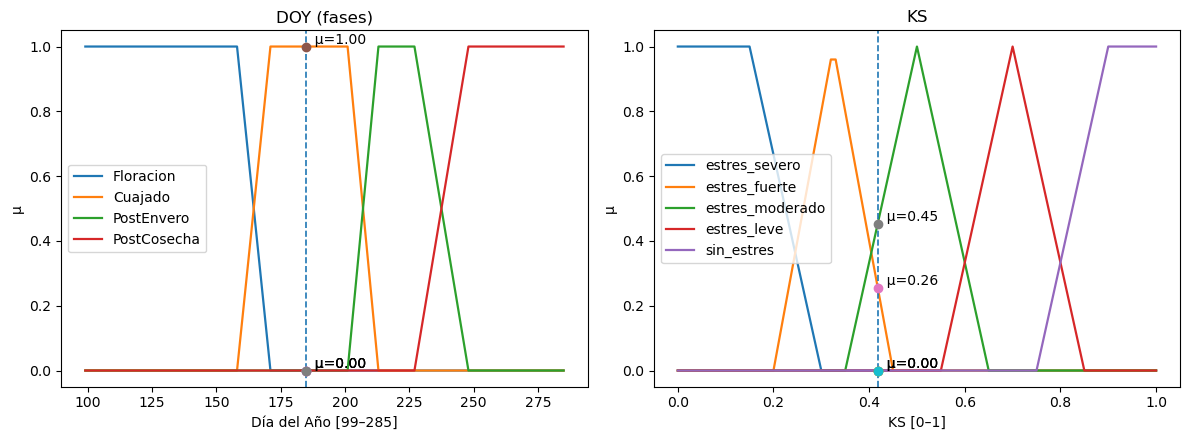

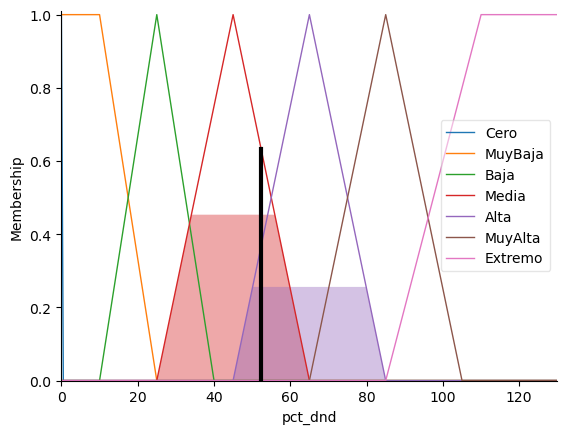

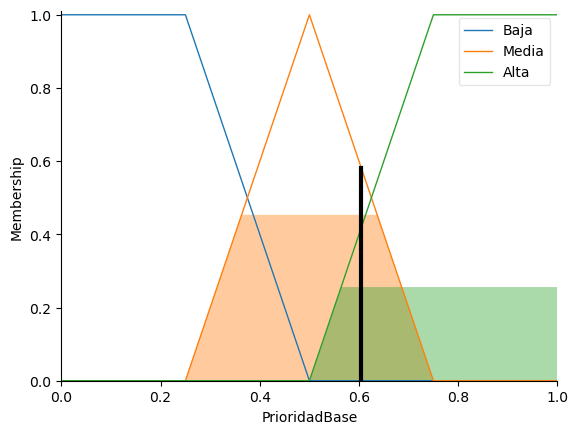

In [13]:
# -*- coding: utf-8 -*-
from __future__ import annotations
from typing import Literal
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt

Fase   = Literal['Floracion', 'Cuajado', 'PostEnvero', 'PostCosecha']
Estres = Literal['estres_severo', 'estres_fuerte', 'estres_moderado', 'estres_leve', 'sin_estres']

class Capa1ConPrioridadKS:
    """
    Capa 1: Sistema de Inferencia Difusa Mamdani (núcleo decisional).
    
    Traduce el estado biofísico (Ks, fase fenológica) en criterios de riego mediante
    lógica difusa. Implementa un sistema Mamdani clásico con operadores min-max y
    defuzzificación por centroide, integrando conocimiento experto local para
    Tempranillo bajo estrategia orientada a calidad.
    
    Entradas:
      - DOY: día del año [99-285], define fase fenológica mediante funciones de pertenencia
      - Ks: coeficiente de estrés hídrico [0-1] de la Capa 0
    
    Salidas:
      - pct_dnd: porcentaje de demanda neta diaria a reponer [0-130%]
      - prioridad: urgencia de riego [0-1], independiente de la dosis
      - fase: etiqueta de fase fenológica actual
    
    La separación dosis/urgencia permite que la Capa 2 ajuste la respuesta operativa
    según restricciones (horas disponibles, caudal, previsión de lluvia) sin perder
    coherencia estratégica.
    """
    
    def __init__(self):
        # Definición de universos de discurso
        self.KS  = ctrl.Antecedent(np.linspace(0.0, 1.0, 101), 'KS')  # Estrés hídrico
        self.DOY = ctrl.Antecedent(np.linspace(99, 285, 285-99+1), 'DOY')  # Día juliano campaña
        
        self.pct  = ctrl.Consequent(np.linspace(0, 130, 261), 'pct_dnd')  # % de DND
        self.Pout = ctrl.Consequent(np.linspace(0, 1.0, 101), 'PrioridadBase')  # Urgencia
        
        # Conjuntos difusos de Ks (niveles de estrés hídrico)
        # Solapamiento permite transiciones suaves entre estados
        self.KS['estres_severo']   = fuzz.trapmf(self.KS.universe, [0.00, 0.00, 0.15, 0.30])
        self.KS['estres_fuerte']   = fuzz.trimf(self.KS.universe,  [0.20, 0.325, 0.45])
        self.KS['estres_moderado'] = fuzz.trimf(self.KS.universe,  [0.35, 0.5, 0.65])
        self.KS['estres_leve']     = fuzz.trimf(self.KS.universe,  [0.55, 0.7, 0.85])
        self.KS['sin_estres']      = fuzz.trapmf(self.KS.universe, [0.75, 0.9, 1.00, 1.00])
        
        # Conjuntos difusos de DOY (fases fenológicas)
        # Rangos basados en fenología típica de Tempranillo en zona centro-norte
        self.DOY['Floracion']   = fuzz.trapmf(self.DOY.universe, [99, 99, 158, 171])  # ~Abril-Mayo
        self.DOY['Cuajado']     = fuzz.trapmf(self.DOY.universe, [158, 171, 201, 213])  # ~Mayo-Junio
        self.DOY['PostEnvero']  = fuzz.trapmf(self.DOY.universe, [201, 213, 227, 248])  # ~Julio-Agosto
        self.DOY['PostCosecha'] = fuzz.trapmf(self.DOY.universe, [227, 248, 285, 285])  # ~Septiembre
        
        # Conjuntos difusos de %DND (porcentaje de demanda neta diaria)
        self.pct['Cero']     = fuzz.trapmf(self.pct.universe, [0, 0, 0, 0])  # Sin riego
        self.pct['MuyBaja']  = fuzz.trapmf(self.pct.universe, [0, 0, 10, 25])  # Déficit severo
        self.pct['Baja']     = fuzz.trimf(self.pct.universe,  [10, 25, 40])  # Déficit moderado
        self.pct['Media']    = fuzz.trimf(self.pct.universe,  [25, 45, 65])  # Reposición parcial
        self.pct['Alta']     = fuzz.trimf(self.pct.universe,  [45, 65, 85])  # Reposición alta
        self.pct['MuyAlta']  = fuzz.trimf(self.pct.universe,  [65, 85, 105])  # Reposición completa+
        self.pct['Extremo']  = fuzz.trapmf(self.pct.universe, [85, 110, 130, 130])  # Urgencia máxima
        self.pct.defuzzify_method = 'centroid'
        
        # Conjuntos difusos de Prioridad (urgencia de riego)
        self.Pout['Baja']  = fuzz.trapmf(self.Pout.universe, [0.00, 0.00, 0.25, 0.50])  # Puede esperar
        self.Pout['Media'] = fuzz.trimf(self.Pout.universe,  [0.25, 0.50, 0.75])  # Atención moderada
        self.Pout['Alta']  = fuzz.trapmf(self.Pout.universe, [0.50, 0.75, 1.00, 1.00])  # Urgente
        self.Pout.defuzzify_method = 'centroid'
        
        # Base de reglas difusas (Fase × Ks) → (pct_dnd, Prioridad)
        # Estructura: 4 fases × 5 niveles de estrés = 20 reglas
        rules = []
        
        # FLORACIÓN: fase crítica, evitar déficits para no comprometer fecundación/cuajado
        # Estrategia: reposición alta incluso con estrés leve
        rules += [
            ctrl.Rule(self.DOY['Floracion'] & self.KS['estres_severo'],   (self.pct['Extremo'],  self.Pout['Alta'])),
            ctrl.Rule(self.DOY['Floracion'] & self.KS['estres_fuerte'],   (self.pct['Extremo'],  self.Pout['Alta'])),
            ctrl.Rule(self.DOY['Floracion'] & self.KS['estres_moderado'], (self.pct['Extremo'],  self.Pout['Alta'])),
            ctrl.Rule(self.DOY['Floracion'] & self.KS['estres_leve'],     (self.pct['MuyAlta'],  self.Pout['Media'])),
            ctrl.Rule(self.DOY['Floracion'] & self.KS['sin_estres'],      (self.pct['Alta'],     self.Pout['Baja'])),
        ]
        
        # CUAJADO: inicio de déficit controlado, reducir vigor excesivo
        # Estrategia: modular según estrés, comenzar a tolerar déficit leve
        rules += [
            ctrl.Rule(self.DOY['Cuajado'] & self.KS['estres_severo'],   (self.pct['MuyAlta'], self.Pout['Alta'])),
            ctrl.Rule(self.DOY['Cuajado'] & self.KS['estres_fuerte'],   (self.pct['Alta'],    self.Pout['Alta'])),
            ctrl.Rule(self.DOY['Cuajado'] & self.KS['estres_moderado'], (self.pct['Media'],   self.Pout['Media'])),
            ctrl.Rule(self.DOY['Cuajado'] & self.KS['estres_leve'],     (self.pct['Baja'],    self.Pout['Media'])),
            ctrl.Rule(self.DOY['Cuajado'] & self.KS['sin_estres'],      (self.pct['MuyBaja'], self.Pout['Baja'])),
        ]
        
        # POST-ENVERO: déficit hídrico controlado para concentración fenólica
        # Estrategia: tolerar estrés moderado, favorecer calidad sobre rendimiento
        rules += [
            ctrl.Rule(self.DOY['PostEnvero'] & self.KS['estres_severo'],   (self.pct['MuyAlta'], self.Pout['Alta'])),
            ctrl.Rule(self.DOY['PostEnvero'] & self.KS['estres_fuerte'],   (self.pct['Media'],   self.Pout['Media'])),
            ctrl.Rule(self.DOY['PostEnvero'] & self.KS['estres_moderado'], (self.pct['Baja'],    self.Pout['Baja'])),
            ctrl.Rule(self.DOY['PostEnvero'] & self.KS['estres_leve'],     (self.pct['MuyBaja'], self.Pout['Baja'])),
            ctrl.Rule(self.DOY['PostEnvero'] & self.KS['sin_estres'],      (self.pct['Cero'],    self.Pout['Baja'])),
        ]
        
        # POST-COSECHA: mantener viabilidad de la planta, evitar estrés extremo
        # Estrategia: riego de supervivencia, preparación para próxima campaña
        rules += [
            ctrl.Rule(self.DOY['PostCosecha'] & self.KS['estres_severo'],   (self.pct['MuyAlta'], self.Pout['Alta'])),
            ctrl.Rule(self.DOY['PostCosecha'] & self.KS['estres_fuerte'],   (self.pct['Alta'],    self.Pout['Alta'])),
            ctrl.Rule(self.DOY['PostCosecha'] & self.KS['estres_moderado'], (self.pct['Media'],   self.Pout['Media'])),
            ctrl.Rule(self.DOY['PostCosecha'] & self.KS['estres_leve'],     (self.pct['Baja'],    self.Pout['Baja'])),
            ctrl.Rule(self.DOY['PostCosecha'] & self.KS['sin_estres'],      (self.pct['Cero'],    self.Pout['Baja'])),
        ]
        
        # Construcción del sistema de control difuso
        self._system = ctrl.ControlSystem(rules)
    
    # ---------- NUEVO: util para dibujar activación de una variable de entrada ----------
    def _plot_antecedent_activation(self, ax, antecedent, xval, title, xlabel):
        # Dibujar MF
        for term_name, term in antecedent.terms.items():
            ax.plot(antecedent.universe, term.mf, label=term_name, linewidth=1.6)
        # Línea vertical en el valor de entrada
        ax.axvline(xval, linestyle='--', linewidth=1.2)
        # Puntos de activación (μ) por término
        for term_name, term in antecedent.terms.items():
            mu = fuzz.interp_membership(antecedent.universe, term.mf, xval)
            ax.plot([xval], [mu], marker='o')
            ax.text(xval, mu, f"  μ={mu:.2f}", va='bottom')
        ax.set_title(title); ax.set_xlabel(xlabel); ax.set_ylabel('μ'); ax.legend(loc='best')

    # ---------- Visualización de MFs con cortes + salidas agregadas ----------
    def visualizar_caso(self, doy: float, ks: float, sim: ctrl.ControlSystemSimulation):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4.5))
        self._plot_antecedent_activation(ax1, self.DOY, doy, 'DOY (fases)', 'Día del Año [99–285]')
        self._plot_antecedent_activation(ax2, self.KS,  ks,  'KS',           'KS [0–1]')
        plt.tight_layout()
        plt.show()

        # Consecuentes con agregación y centroide (aprovechamos el view de skfuzzy)
        self.pct.view(sim=sim)      # muestra agregación y centroide de %DND
        self.Pout.view(sim=sim)     # muestra agregación y centroide de Prioridad
        plt.show()

    # ---------- API mínima ----------
    def evaluar(self, doy: float, ks: float):
        """Evalúa la Capa 1 (sin gate por lluvia)."""
        doy = float(np.clip(doy, 99, 285))
        ks  = float(np.clip(ks,  0.0, 1.0))

        sim = ctrl.ControlSystemSimulation(self._system)
        sim.input['DOY'] = doy
        sim.input['KS']  = ks
        sim.compute()

        out = {
            'pct_dnd': round(float(sim.output['pct_dnd']), 2),
            'prioridad': round(float(sim.output['PrioridadBase']), 3),
            'fase': self._fase_label_por_max_mu(doy),
            'sim': sim,  # << devolvemos la simulación para usar en los gráficos de salida
        }
        return out

    # ---------- Utilidades ----------
    def _fase_label_por_max_mu(self, doy: float) -> Fase:
        mu = {
            'Floracion':   fuzz.interp_membership(self.DOY.universe, self.DOY.terms['Floracion'].mf,  doy),
            'Cuajado':     fuzz.interp_membership(self.DOY.universe, self.DOY.terms['Cuajado'].mf,    doy),
            'PostEnvero':  fuzz.interp_membership(self.DOY.universe, self.DOY.terms['PostEnvero'].mf, doy),
            'PostCosecha': fuzz.interp_membership(self.DOY.universe, self.DOY.terms['PostCosecha'].mf, doy),
        }
        return max(mu, key=mu.get)  # type: ignore[return-value]


# -------- Ejemplo de uso con TUS DATOS (salida Capa 0) --------
if __name__ == "__main__":
    capa1 = Capa1ConPrioridadKS()

    # Datos reales del ejemplo (Capa 0): J = 185, Ks = 0.598 
    doy_ej = 185
    ks_ej  = 0.418

    out = capa1.evaluar(doy=doy_ej, ks=ks_ej)
    print(f"Entrada: DOY={doy_ej}, KS={ks_ej:.3f}  →  %DND={out['pct_dnd']}  Prioridad={out['prioridad']}  Fase={out['fase']}")

    # Visualizaciones con cortes en entradas y agregación en salidas
    capa1.visualizar_caso(doy=doy_ej, ks=ks_ej, sim=out['sim'])
